# Application of an LDA Topic Model to our corpus

In [1]:
#Special module written for this class
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

# import scipy #For hierarchical clustering and some visuals
from scipy import stats
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

import pandas as pd
# import itertools
from itertools import combinations
from functools import reduce
import json

%matplotlib inline

In [3]:
news_df1 = pd.read_pickle('../news_df_norm1.pkl')
news_df2 = pd.read_pickle('../news_df_norm2.pkl')
news_df = pd.concat([news_df1, news_df2])

In [6]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]


def topic_loop(df, num_topic, max_df, max_feature, norm, alpha, eta, random_number=None):
    """
    Outputs top topics words according throughout all the hyperparameter combinations.
    Params:
        df: Dataframe with text to be analyzed. Requires column named "normalized tokens" with text 
            as tokens that have been stemmed and lemmatized.
        random_number: Seed for the LdaModel. Default None will give out a different model every 
            time for the same parameter combination.
        All other parameters are lists of that param name to be passed to gensim.LdaModel
    """
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=max_df, min_df=20, 
                                                                   max_features=max_feature, stop_words=basic_cc)
    TFVects = TFVectorizer.fit_transform(df['text'])

    # drop
    reduced_token_str = 'reduced_tokens_' + norm
    norm_col = 'normalized_tokens' + norm
    df[reduced_token_str] = df[norm_col].apply(lambda x: dropMissing(x, TFVectorizer.vocabulary_.keys()))

    # Make dictionary
    dictionary = gensim.corpora.Dictionary(df[reduced_token_str])

    # Make corpus
    corpus = [dictionary.doc2bow(text) for text in df[reduced_token_str]]

    # Serialize
    serial_str = 'news.mm'
    gensim.corpora.MmCorpus.serialize(serial_str, corpus)
    #newsm = gensim.corpora.MmCorpus(serial_str)

    # Topic model
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
                                          alpha=alpha, eta=eta, random_state=random_number)
    topicsDict = {}
    for topicNum in range(lda.num_topics):
        topicWords = [w for w in lda.show_topic(topicNum, topn=20)]
        topicsDict['Topic_{}'.format(topicNum)] = topicWords
    wordRanksDF = pandas.DataFrame(topicsDict)

    # Topics per document
    ldaDF = pandas.DataFrame({
            'name' : [df.iloc[i,1] + '_' + df.iloc[i,7] for i in range(df.shape[0])],
            'topics' : [lda[dictionary.doc2bow(l)] for l in df[reduced_token_str]]})    
    topicsProbDict = {i : [0] * len(ldaDF) for i in range(lda.num_topics)}
    for index, topicTuples in enumerate(ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob
    for topicNum in range(lda.num_topics):
        ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
    return wordRanksDF, ldaDF

Incorporating some repeated, non-meaningful words to our stopwords list, and setting the parameters for our topic modelling

In [10]:
basic_cc = lucem_illud.stop_words_basic + ['climat', 'chang', 'like', 'year','mr', 'say','could']

num_topic = 3
max_df = 0.5
max_feature = 1000
norm = '_stem'

alpha = 0.1
eta = 0.1

<br> To assess topic stability, we repeat the process without seed and measure similarity between the topics created.

In [18]:
topic_words1, topic_per_doc1 = topic_loop(news_df, num_topic, max_df, max_feature, norm, alpha, eta)

In [19]:
topic_words2, topic_per_doc2 = topic_loop(news_df, num_topic, max_df, max_feature, norm, alpha, eta)

In [20]:
topic_words3, topic_per_doc3 = topic_loop(news_df, num_topic, max_df, max_feature, norm, alpha, eta)

In [21]:
topic_words4, topic_per_doc4 = topic_loop(news_df, num_topic, max_df, max_feature, norm, alpha, eta)

In [22]:
topic_words5, topic_per_doc5 = topic_loop(news_df, num_topic, max_df, max_feature, norm, alpha, eta)

In [23]:
def jaccard_similarity(x,y):
    """
    http://www.pressthered.com/adding_dates_and_times_in_python/
    Given two lists, returns their jaccard similarity score (float)
    """
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))

    if union_cardinality != 0:
        val = intersection_cardinality/float(union_cardinality)
    else:
        val = 0  #if two empty sets are given, return 0 instead of an error
    return val

In [24]:
def topWordStability(topic_words1, topic_words2, typ):
    top_corrs = []
    for t1 in range(topic_words1.shape[1]):
        t1_corrs = []
        topic_num1 = 'Topic_' + str(t1)
        words1 = [topic_words1[topic_num1][i][0] for i in range(len(topic_words1))]
        
        for t2 in range(topic_words2.shape[1]):
            topic_num2 = 'Topic_' + str(t2)
            words2 = [topic_words2[topic_num2][i][0] for i in range(len(topic_words2))]
            
            if typ == 'j':
                corr = jaccard_similarity(words1, words2)
                t1_corrs.append((topic_num1, topic_num2, corr))
            elif typ == 's':
                corr = stats.spearmanr(words1, words2)
                t1_corrs.append((topic_num1, topic_num2, corr[0]))
        t1_top = [t1_corrs[i][2] for i in range(len(t1_corrs))]
        ind = t1_top.index(max(t1_top))
        top_corrs.append(t1_corrs[ind])
    return top_corrs

In [29]:
topWordStability(topic_words1, topic_words2, 'j')

[('Topic_0', 'Topic_1', 0.42857142857142855),
 ('Topic_1', 'Topic_1', 0.3793103448275862),
 ('Topic_2', 'Topic_1', 0.3333333333333333)]

In [25]:
def averageWordStability(topic_words_list, num_topic, typ):
    all_combo_corrs = []
    for i in range(len(topic_words_list)):
        for j in range(len(topic_words_list)):
            if j > i:
                top_corrs = topWordStability(topic_words_list[i], topic_words_list[j], typ)
                all_combo_corrs.append(('gr'+str(i), 'gr'+str(j), top_corrs))
    
    avg_corrs = []
    for t in range(num_topic):
        corrs = [all_combo_corrs[i][2][t][2] for i in range(len(all_combo_corrs))]
        avg = reduce(lambda x, y: x + y, corrs) / len(corrs)
        avg_corrs.append((t, avg))
    return avg_corrs

In [26]:
topic_words_list = [topic_words1, topic_words2, topic_words3, topic_words4, topic_words5]

In [27]:
averageWordStability(topic_words_list, 3, 's')

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


[(0, 0.30992481203007516), (1, 0.36721804511278194), (2, 0.09984962406015037)]

Looking at the word distribution for each of the topics

In [12]:
def topicWordGraph(topic_words):
    for t in range(topic_words.shape[1]):
        topic_df = topic_words['Topic_' + str(t)]
        words = [topic_df[i][0] for i in range(len(topic_df))]
        probs = [topic_df[i][1] for i in range(len(topic_df))]
        
        plt.figure()
        pd.DataFrame(np.array(probs)).plot.bar(legend = False)
        plt.xticks(list(range(0,topic_words.shape[0])), words, rotation=45)
        plt.title('Probability Distribution of Words, Topic ' + str(t))
        plt.show()

<Figure size 432x288 with 0 Axes>

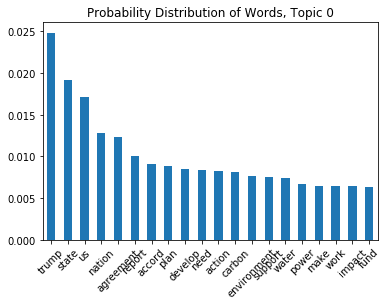

<Figure size 432x288 with 0 Axes>

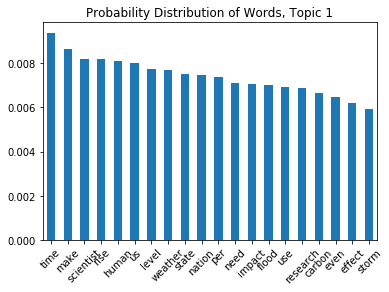

<Figure size 432x288 with 0 Axes>

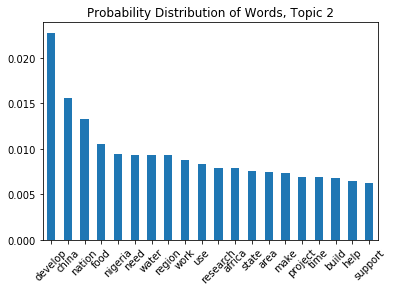

In [13]:
topicWordGraph(topic_words1)

## We use the topic proportions to make statements about which countries devote their news to. Here we make and plot this calculation

In [14]:
def averageTopicProportions(topic_per_doc):
    """
    Calculates and plots average topic proportions per country given a topics per document dataframe
    """
    topic_per_doc['country'] = [topic_per_doc.iloc[i,0][:2] for i in range(topic_per_doc.shape[0])]
    group_country = topic_per_doc.groupby(['country']).mean().reset_index()
    topics = {}
    
    for t in range(group_country.shape[1] - 1):
        key = 'topic_' + str(t)
        val = group_country[key]
        topics[key] = val
    
    df = pd.DataFrame(topics)
    df.plot(kind='bar', stacked=True)
    plt.xticks(list(range(group_country.shape[0])), group_country['country'])

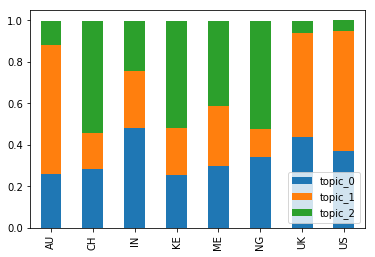

In [15]:
averageTopicProportions(topic_per_doc1)

In [16]:
def topTopic(topic_per_doc, num_topics):
    """
    Calculates and plots topic proportions per country using only the most salient topic per document.
    """
    topic_per_doc['country'] = [topic_per_doc.iloc[i,0][:2] for i in range(topic_per_doc.shape[0])]
    
    # Find max topic proportion per document
    for i in range(topic_per_doc.shape[0]):
        props = []
        for t in range(num_topics):
            props.append(topic_per_doc.iloc[i,t+2])
        tmp = max(props)
        mx = props.index(tmp)
        topic_per_doc.loc[i, 'top_topic'] = mx
        
    # Create pivot table of number of docs per topic by country
    d = pd.pivot_table(topic_per_doc, values=['name'], index=['country'], columns=['top_topic'], aggfunc='count').reset_index()
    
    # Convert number to proportion
    countries = [d.values[i][0] for i in range(len(d.values))]
    tots = [d.values[i][1:].sum() for i in range(len(d.values))]
    df_dict = {'country': countries}
    for t in range(num_topics):
        df_dict['topic_' + str(t)] = [d.values[i][t+1]/tots[i] for i in range(len(d.values))]
    df = pd.DataFrame(df_dict)
    
    # Stack proportions for graph
    topics = {}
    for t in range(df.shape[1] - 1):
        key = 'topic_' + str(t)
        val = df[key]
        topics[key] = val
    df2 = pd.DataFrame(topics)
    df2.plot(kind='bar', stacked=True)
    plt.xticks(list(range(df.shape[0])), df['country'])

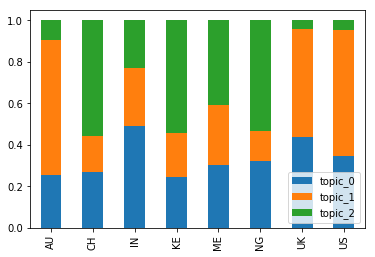

In [17]:
topTopic(topic_per_doc1, 3)